In [1]:
#SOURCES

#http://cshprotocols.cshlp.org/content/2015/4/pdb.top086124.long
#https://scipy-cookbook.readthedocs.io/items/FittingData.html

In [2]:
#IMPORTING DEPENDENCIES

import cv2
from skimage.transform import rescale, resize, downscale_local_mean

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

from astropy.modeling import models, fitting
import warnings

import matplotlib.cm as cm
import sklearn.preprocessing

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage as ndimage

from skimage.draw import line
from skimage.draw import line_aa

In [3]:
#FUNCTIONS

def crop_center(img,cropx,cropy):
    """Crop a centered rectangle or square"""
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

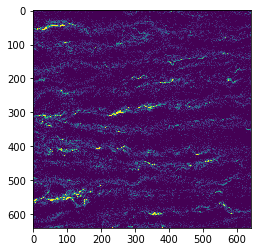

In [60]:
#LOADING FILE

#filelocate = 'CollagenMedia2.tif'
filelocate = 'Collagen150.tif'
#filelocate1 = 'C:/Users/kkolos/Documents/SpIDA/GUI_SpIDA_v1.3_Eduardo/TestImage_mGFP-f.tif'
#filelocate = 'C:/Users/kkolos/Desktop/collagen-wave/CollagenMedia2.tif'
#filelocate = 'C:/Users/kkolos/Desktop/collagen-wave/Elastin150.tif'


image = cv2.imread(filelocate)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#img=img[0:257,0:257]

plt.imshow(img,cmap='viridis')
plt.show()

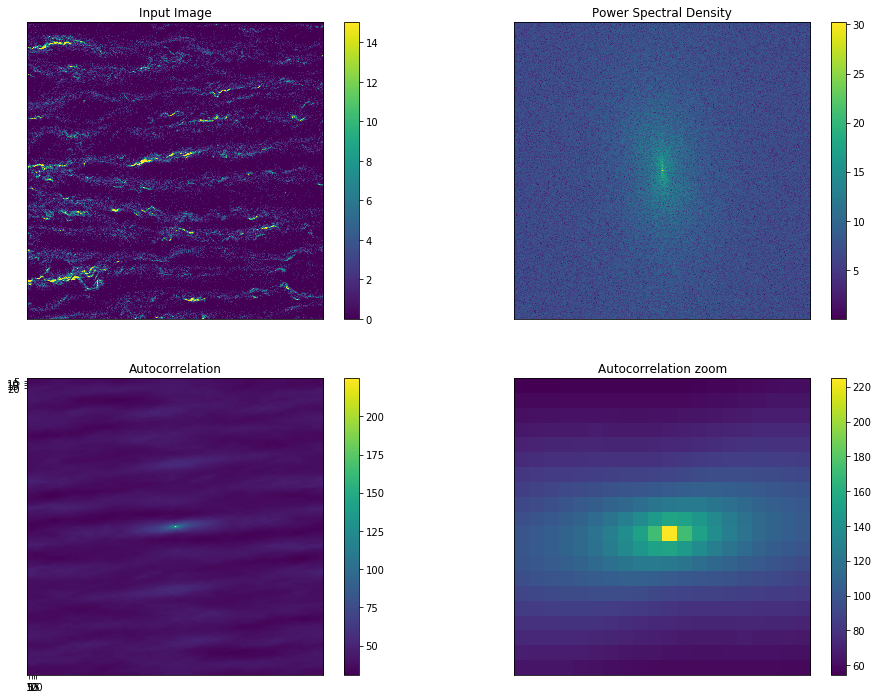

In [61]:
#AUTOCORRELATION

#imgforft=gausskern*1
#imgforft=simfibimg*1
imgforft=img
#plotcorr=np.real(np.fft.fft2(imgforft))

#dft = cv2.dft(np.float32(imgforft),flags = cv2.DFT_COMPLEX_OUTPUT)
#dft_shift = np.fft.fftshift(dft)

myft=(np.log10(abs(np.fft.fftshift(np.fft.fft2(imgforft)))))**2
    
plotcorr=(np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(imgforft)*np.conjugate(np.fft.fft2(imgforft)))))/((np.mean(imgforft)*np.mean(imgforft)*100*100 )))-1

plotcorrzoom=crop_center(plotcorr,20,20)

#magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
#powerspectraldensity = magnitude_spectrum**2
plt.figure(figsize=(16,12))
plt.subplot(221),plt.imshow(imgforft)
plt.colorbar()
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(myft)
plt.colorbar()
plt.title('Power Spectral Density'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(plotcorr)
plt.colorbar()
plt.title('Autocorrelation'), plt.xticks([5,10,15,20]), plt.yticks([5,10,15,20])
plt.subplot(224),plt.imshow(plotcorrzoom)
plt.colorbar()
plt.title('Autocorrelation zoom'), plt.xticks([]), plt.yticks([])
plt.show()


In [62]:
density=1/(plotcorr[50,50])
#(density,plotcorr[12,12])
density


0.025617056649450295

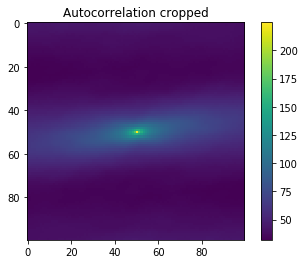

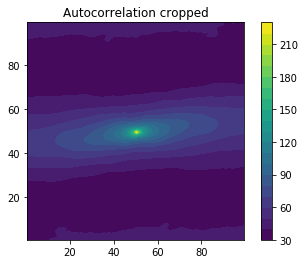

In [63]:
#newimg=crop_center(plotcorr,100,200)*1
newimg=crop_center(plotcorr,100,100)
plt.imshow(newimg)
plt.colorbar()
plt.title('Autocorrelation cropped')
plt.show()
plt.contourf(newimg,20,origin='upper')
plt.colorbar()
plt.title('Autocorrelation cropped')
plt.gca().axes.set_aspect('equal')
plt.show()

In [64]:
newimg.shape

(100, 100)

In [65]:
#ignore max point when f
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(newimg)
newimgmask=newimg*1
newimgmask[max_loc]=np.nan
mat=newimgmask*1
newimg2=newimgmask*1

rows, cols = mat.shape
xv, yv = np.meshgrid(range(cols), range(rows)[::-1])


mask1=np.ma.masked_invalid(newimg2)

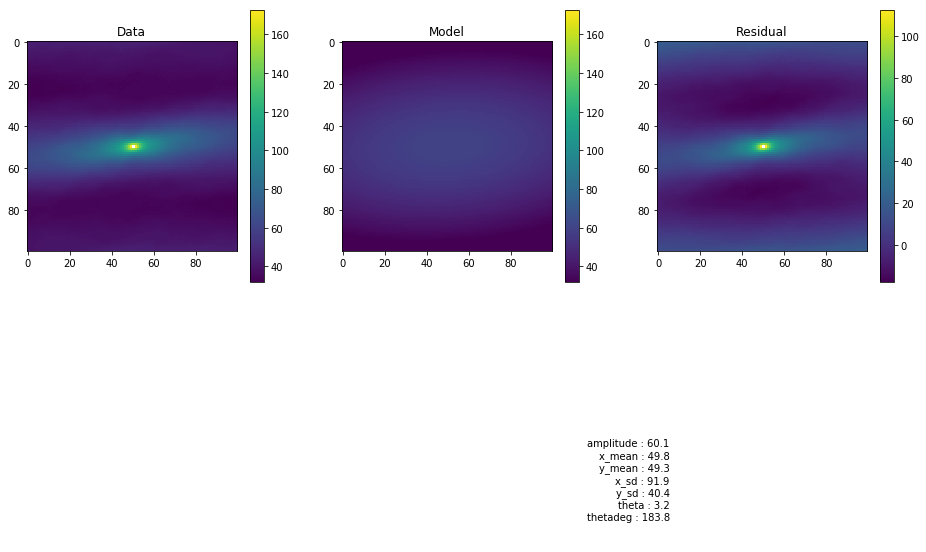

In [66]:
import scipy.optimize

def scipyFunc(parameters, xv,yv, image):
    amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=parameters
    p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)
    return np.nanmean((image-p(xv,yv))**2)


cols,rows=newimgmask.shape

fitted=scipy.optimize.minimize(scipyFunc,(60,cols/2,rows/2,1,1,0),(xv,yv,mask1)).x

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta=fitted
p = models.Gaussian2D(amplitude=amplitude,x_mean=x_mean,y_mean=y_mean,x_stddev=x_stddev,y_stddev=y_stddev,theta=theta)


# Plot the data with the best-fit model
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask1, interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Data")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(p(xv, yv), interpolation='nearest',vmax=np.nanmax(mask1),vmin=np.nanmin(mask1))
plt.title("Model")
ax = plt.gca()
thetadeg=p.theta.value*180/np.pi
plt.text(1.56, -1.4, """
amplitude : %.1f
x_mean : %.1f
y_mean : %.1f
x_sd : %.1f
y_sd : %.1f
theta : %.1f
thetadeg : %.1f

""" %(amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,thetadeg),
        fontsize=10, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(newimg2 - p(xv, yv), interpolation='nearest')
plt.title("Residual")
plt.colorbar()
plt.show()


In [67]:
scipyFunc(fitted,xv,yv, mask1)

157.09835190977446

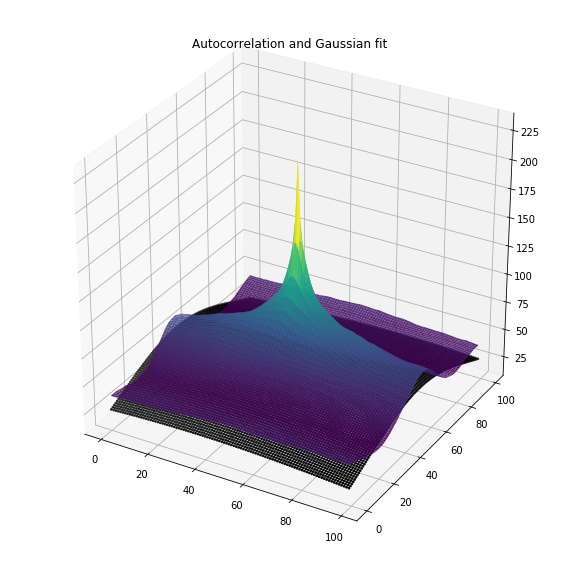

In [68]:

fig=plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(xv, yv, p(xv,yv), c='black', s=3)
ax.plot_surface(xv, yv, newimg, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.9)

ax.set_title('Autocorrelation and Gaussian fit');
plt.show()